In [7]:
# imports
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvr
from torchvr.samplers import Uniform, Mabs, Vrb, AdaSample

from utils import Problem, fit

In [8]:
# Generates the data
N = 100
d = 10

# generates the features
# the gradient norms are set to be proportional to lognormal random variables
norms = (torch.randn(N)).exp()
X = torch.randn(N, d)
X /= X.pow(2).sum(dim=1).unsqueeze(1)
X *= norms.unsqueeze(1)

# generates the targets from a linear normal model
true_weight = torch.randn(d)
y = X @ true_weight + torch.randn(N)

In [9]:
# defines the model
class Linear_regression(torch.nn.Module):
    
    def __init__(self, d):
        super().__init__()
        self.lin = torchvr.layers.IsLinear(d, 1, bias=False)
    
    def forward(self, input, weights_grads=None):
        output = self.lin(input, weights_grads)
        return output.squeeze(1)

# initializes the model and the loss function
model = Linear_regression(d)
loss_func = torch.nn.MSELoss(reduction='sum')
reg = 0.0

# calculates the optimal function value
weight_star = torch.solve((X.T @ y).unsqueeze(1), (X.T @ X))[0].squeeze(1)
loss_star = loss_func(X @ weight_star, y)

# saves starting point
start = deepcopy(model.state_dict())
start["lin.weight"] = weight_star + 0.25 * torch.randn_like(model.lin.weight)

problem = Problem(X, y, model, start, loss_func, reg)

## batch size 1

In [10]:
# general parameters
epochs = 100
runs = 10
batch_size = 1

L = 2 * torch.symeig(X.t() @ X)[0][-1]
L_max = 2 * max(X.pow(2).sum(dim=1))
mu = 2 * torch.symeig(X.t() @ X)[0][0]
G = 2 * max(X.pow(2).sum(dim=1).sqrt())
lr = batch_size/(2*N*L_max)

## constant step size

In [11]:
samplers = dict()
samplers["Uniform"] = Uniform(X, model.parameters(), batch_size)
samplers["MABS"] = Mabs(X, model.parameters(), batch_size,G=G, T=epochs*len(X))
samplers["VRB"] = Vrb(X, model.parameters(), batch_size, G=G, T=epochs*len(X))
samplers["AdaSample"] = AdaSample(X, model.parameters(),batch_size, p_min=1/(5*N))

In [12]:
results = dict()
for name, sampler in samplers.items():
    results[name] = fit(problem, sampler, lr, runs=runs,  epochs=epochs)

100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


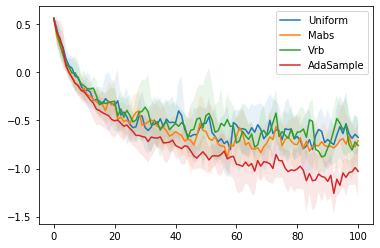

In [13]:
plt.plot()
for result in results.values():
    result.all_results(loss_star)
    result.plt_results("subopts")
plt.legend()

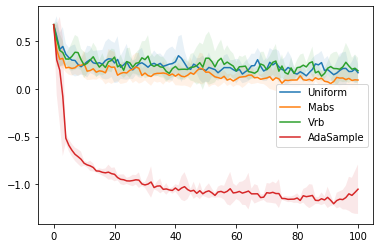

In [14]:
plt.plot()
for result in results.values():
    result.all_results(loss_star)
    result.plt_results("per_step_relative_regrets")
plt.legend()

## decreasing step size

In [24]:
schedule_lr = lambda num_iter : batch_size/(2*N*L_max + batch_size * mu * num_iter)

In [25]:
samplers = dict()
samplers["Uniform"] = Uniform(X, model.parameters(), batch_size)
samplers["MABS"] = Mabs(X, model.parameters(), batch_size,G=G, T=epochs*len(X))
samplers["VRB"] = Vrb(X, model.parameters(), batch_size, G=G, T=epochs*len(X))
samplers["AdaSample"] = AdaSample(X, model.parameters(),batch_size)

In [26]:
results = dict()
for name, sampler in samplers.items():
    results[name] = fit(problem, sampler, lr, schedule_lr, runs=runs, epochs=epochs)

100%|██████████| 10/10 [00:50<00:00,  5.07s/it]


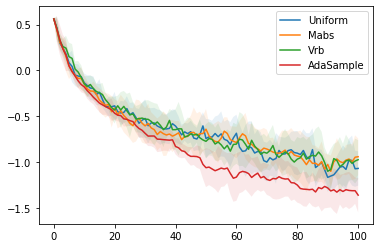

In [27]:
plt.plot()
for result in results.values():
    result.all_results(loss_star)
    result.plt_results("subopts")
plt.legend()

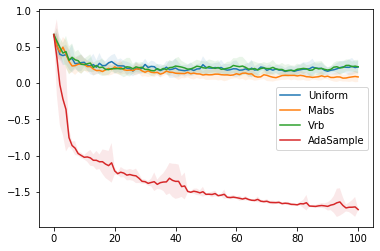

In [28]:
plt.plot()
for result in results.values():
    result.all_results(loss_star)
    result.plt_results("per_step_relative_regrets")
plt.legend()